# <font color='red'> Introduction to Prophet </font>

In this notebook, we are going to learn about [Prophet](https://research.fb.com/prophet-forecasting-at-scale/), a python library released by facebook to perform **automated time series modelling** that is, to automatically forecast future values from a time series. Pretty cool!. 

You can read how to install here: [Prophet](https://facebook.github.io/prophet/docs/installation.html)

Note that Prophet is a massive package with a lot of dependencies, in future I'd recommend making a new [conda environment](https://medium.com/data-folks-indonesia/installing-fbprophet-prophet-for-time-series-forecasting-in-jupyter-notebook-7de6db09f93e)  for working with it.


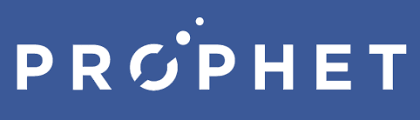

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(rc={'figure.figsize':(16,5)})

import matplotlib.pyplot as plt

### <font color='red'> Bitcoin Data </font>

We are going to use a dataset that includes the bitcoin price for the period 2017-2018.

In [ ]:
data = pd.read_csv('data/bitcoin.csv') 
data.head()

In [ ]:
data.shape

Prophet requires the data to have 2 columns, `ds` with the timestamp and `y` with the target variable

In [ ]:
data["ds"] = pd.to_datetime(data.Timestamp)
data["y"] = data.Weighted_Price
data = data[["ds", "y"]]
data.head()

The bitcoin data is in minutes, prophet works best with hourly/daily/weekly data, so we will resample it to hourly

In [ ]:
data = data.set_index("ds").resample('H').mean().reset_index(drop=False)

In [ ]:
data.shape

In [ ]:
plt.plot(data.ds, data.y)

In [ ]:
data.ds.describe()

### <font color='red'> Prophet </font>

Now we import prophet

In [ ]:
from prophet import Prophet

### <font color='red'> Fit the model </font>

We create a `Prophet` model object to train and make predictions.

In [ ]:
m = Prophet(yearly_seasonality=False, weekly_seasonality="auto", daily_seasonality="auto")

Now we fit the model to the data

In [ ]:
%time m.fit(data) # takes about 40 seconds 

### <font color='red'> Validate our model </font>

Prophet has [some functions](https://facebook.github.io/prophet/docs/diagnostics.html) to evaluate Time series models. For example, we can do model crossvalidation, using the `diagnostics.cross_validation function`

![](https://facebook.github.io/prophet/static/diagnostics_files/diagnostics_3_0.png)

Basically it trains multiple prophet models, given an `initial` number of periods to use as training data,  and evaluate the models on the predictions on a given `horizon` period. If we dont want to run as many predictions as periods on the training dataset we can pass the parameter `period` (to run the predictions every period time)

In [ ]:
from prophet.diagnostics import cross_validation

In [ ]:
cv_results = cross_validation(m,  initial="60 days", horizon="7 days", period="15 days")

In [ ]:
cv_results.shape

In [ ]:
cv_results.head(10)

We can compute metrics by horizon with the function `performance_metrics`, it will print out common metrics for each horizon we have taken. Usually the farther the horizon, the bigger the error.

In [ ]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(cv_results)
df_p.head(20)

# this gives us the metrics for each period forward we are trying to predict. Generally the further out we are trying to predict the less accurate our forecasts are going to be.
#this is much easier to visualise in a plot

We can use the function `plot_cross_validation_metric` to assess how prophet model performs.

Dots show the absolute percent error for each prediction in df_cv. The blue line shows the MAPE, where the mean is taken over a rolling window of the dots. We see for this forecast that errors around 0.13 are typical for predictions seven days into the future.

In [ ]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(cv_results, metric='mape')

### <font color='red'> Make future predictions </font>

Now we are ready to make predictions. To do so we just need to fill the `ds` column with future timestamps. Prophet has the utility function `make_future_dataframe()` that creates a dataframe with future timestamps.

By default, this method creates a dataframe with the same timestamps as the training dataset **plus** as many periods as we want in the future. If we only care about creating a dataset with future dates we can use the argument `include_history=False` (it is true by default).

In [ ]:
# this makes an empty data frame for which we are going to predict the values
future = m.make_future_dataframe(periods=30, include_history=True) 
future.head()

Now we can forecast using the method `predict`.

In [ ]:
forecast = m.predict(future)

In [ ]:
forecast.head()

We can plot the forecast and see the confidence levels the model has. As time passes it becomes less and less sure about its predictions, which makes sense since this series is pretty volatile.

In [ ]:
m.plot(forecast);

We can get the time series decomposition with `plot_components`

In [ ]:
 m.plot_components(forecast);

This is just the basics of prophet, you can check [this article](https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3) for more in depth techniques